In [1]:
from xmlrpc.client import Binary

import copick
import keras.src.losses
import pandas as pd
import zarr
from matplotlib import pyplot as plt
import os
import json
import numpy as np
from keras import layers, models
import matplotlib.patches as patches
from keras.api.losses import BinaryCrossentropy
from keras.api.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from sklearn.utils.extmath import cartesian
from tensorflow.python.ops.gen_nn_ops import Conv3D, max_pool
from tqdm import tqdm
from numba import njit, prange
import datetime
import tensorflow as tf


In [2]:
def get_copick_root(split):
    """
    Loads the copick configuration based on the split.

    Args:
        split (str): 'train' or 'test'.

    Returns:
        copick_root: The loaded copick configuration.
    """
    config_path = '../../../copick_config.json' if split == 'train' else '../../../copick_config_test.json'
    if not os.path.exists(config_path):
        raise FileNotFoundError(f"Configuration file not found: {config_path}")
    copick_root = copick.from_file(config_path)
    return copick_root


In [3]:
def get_static_tomogram(run_name, split='train', tomo_type='denoised', zarr_group_idx=0):
    """
    Retrieves a static tomogram from the copick dataset.

    Args:
        run_name (str): Name of the run.
        split (str): 'train' or 'test'.
        tomo_type (str): Type of tomogram.
        zarr_group_idx (int): Index of the Zarr group.

    Returns:
        np.ndarray: The tomogram data as a NumPy array.
    """
    copick_root = get_copick_root(split)
    run = copick_root.get_run(run_name)
    voxel_spacing = run.get_voxel_spacing(10.000)
    tomogram = voxel_spacing.get_tomogram(tomo_type)
    zarr_store = tomogram.zarr()
    zarr_group = zarr.open(zarr_store, mode='r')
    try:
        tomogram_vals = zarr_group[str(zarr_group_idx)][:]  # Use string keys if necessary
    except KeyError:
        raise KeyError(f"Zarr group index {zarr_group_idx} not found in the store.")
    return tomogram_vals


In [4]:
def get_label_locations(run_name, copick_root, voxel_spacing=10):
    """
    Extracts label locations from JSON files for a given run.

    Args:
        run_name (str): Name of the run.
        copick_root: Copick root object.
        voxel_spacing (float): Voxel spacing for normalization.

    Returns:
        dict: Dictionary with particle names as keys and arrays of locations as values.
    """
    picks_folder = os.path.join(copick_root.config.overlay_root, 'ExperimentRuns', run_name, 'Picks')
    if not os.path.exists(picks_folder):
        raise FileNotFoundError(f"Picks folder not found: {picks_folder}")

    picks = {}
    for json_file in os.listdir(picks_folder):
        if json_file.endswith('.json'):
            json_path = os.path.join(picks_folder, json_file)
            with open(json_path, 'r') as file:
                pick_data = json.load(file)
            particle_name = json_file[:-5]  # Remove '.json' extension
            picks[particle_name] = np.array([
                [
                    point['location']['x'] / voxel_spacing,
                    point['location']['y'] / voxel_spacing,
                    point['location']['z'] / voxel_spacing
                ]
                for point in pick_data.get('points', [])
            ])
    return picks


In [5]:
# Load copick configurations
copick_root_train = get_copick_root('train')
copick_root_test = get_copick_root('test')


In [6]:
# Retrieve run names
training_runs = copick_root_train.runs
testing_runs = copick_root_test.runs

training_run_names = [run.name for run in training_runs]
testing_run_names = [run.name for run in testing_runs]
extra_training_run_names = list(set(training_run_names) - set(testing_run_names))

print(f'Training runs: {training_run_names}')
print(f'Testing runs: {testing_run_names}')
print(f'Extra training runs not in testing: {extra_training_run_names}')


Training runs: ['TS_5_4', 'TS_69_2', 'TS_6_4', 'TS_6_6', 'TS_73_6', 'TS_86_3', 'TS_99_9']
Testing runs: ['TS_5_4', 'TS_69_2', 'TS_6_4']
Extra training runs not in testing: ['TS_86_3', 'TS_73_6', 'TS_6_6', 'TS_99_9']


In [7]:
# Load tomograms
tomograms_train = []
tomograms_test = []

for training_run_name in training_run_names:
    try:
        tomo = get_static_tomogram(split='train', run_name=training_run_name)
        tomograms_train.append({'run': training_run_name, 'tomogram': tomo})
    except Exception as e:
        print(f"Error loading tomogram for run {training_run_name}: {e}")

for testing_run_name in testing_run_names:
    try:
        tomo = get_static_tomogram(split='test', run_name=testing_run_name)
        tomograms_test.append({'run': testing_run_name, 'tomogram': tomo})
    except Exception as e:
        print(f"Error loading tomogram for run {testing_run_name}: {e}")

print(f'Number of train tomograms: {len(tomograms_train)}')
print(f'Number of test tomograms: {len(tomograms_test)}')


Number of train tomograms: 7
Number of test tomograms: 3


In [8]:
# Verify the loaded tomograms
if tomograms_train:
    sample_tomo = tomograms_train[0]['tomogram']
    print(f"Type: {type(sample_tomo)}")
    print(f"Element Type: {type(sample_tomo[0])}")
    print(f"Shape: {sample_tomo.shape}")
else:
    print("No training tomograms loaded.")


Type: <class 'numpy.ndarray'>
Element Type: <class 'numpy.ndarray'>
Shape: (184, 630, 630)


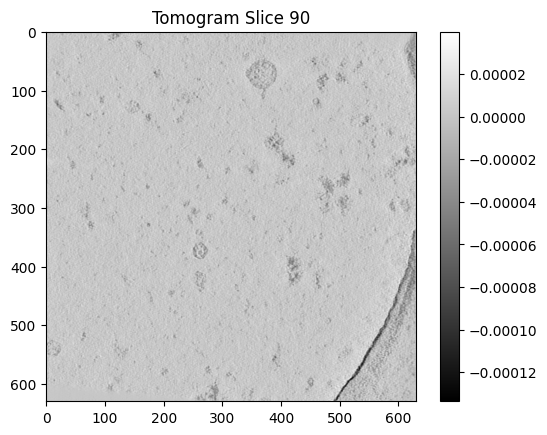

In [9]:
# Visualize a slice
if tomograms_train:
    slice_index = 90  # Adjust as needed
    if slice_index < tomograms_train[0]['tomogram'].shape[0]:
        plt.imshow(tomograms_train[0]['tomogram'][slice_index], cmap='gray')
        plt.title(f"Tomogram Slice {slice_index}")
        plt.colorbar()
        plt.show()
    else:
        print(
            f"Slice index {slice_index} out of range for tomogram with depth {tomograms_train[0]['tomogram'].shape[0]}")
else:
    print("No training tomograms to visualize.")


In [10]:
# Create DataFrame with particle locations
rows = []
for run in training_run_names:
    try:
        label_data = get_label_locations(run, copick_root_train)
        for particle, locations in label_data.items():
            matching_particles = [obj.radius for obj in copick_root_train.config.pickable_objects if
                                  obj.name == particle]
            if not matching_particles:
                print(f"No matching particle found for {particle} in run {run}")
                continue
            radius = matching_particles[0] / 10
            for location in locations:
                rows.append({
                    'run': run,
                    'particle': particle,
                    'x': location[0],
                    'y': location[1],
                    'z': location[2],
                    'radius': radius
                })
    except Exception as e:
        print(f"Error processing labels for run {run}: {e}")

particle_locations_df = pd.DataFrame(rows)
print(particle_locations_df.sample(5))
print(f"Total labeled particles: {len(particle_locations_df)}")

          run             particle         x         y         z  radius
276   TS_69_2        thyroglobulin  622.9592   39.4490  128.6327    13.0
1202  TS_99_9         apo-ferritin  459.2044  132.1788   32.2883     6.0
851   TS_86_3             ribosome  581.5688  591.0474  111.2865    15.0
180   TS_69_2  virus-like-particle  258.7613  136.0659   81.4115    13.5
1204  TS_99_9         apo-ferritin  439.5130  189.2857   35.2013     6.0
Total labeled particles: 1269


In [53]:
def compute_ground_truth_boxes(df):
    """
    Computes ground truth bounding boxes from particle center points and radii.

    Args:
        df (pd.DataFrame): DataFrame with columns ['run', 'particle', 'x', 'y', 'z', 'radius'].

    Returns:
        np.ndarray: Array of ground truth boxes with shape (N, 6), where each box is (x_min, y_min, z_min, x_max, y_max, z_max).
        np.ndarray: Array of corresponding particle labels (strings).
    """
    # Compute the min and max bounds for each box
    x_min = df['x'] - df['radius']
    x_max = df['x'] + df['radius']
    y_min = df['y'] - df['radius']
    y_max = df['y'] + df['radius']
    z_min = df['z'] - df['radius']
    z_max = df['z'] + df['radius']
    
    # Combine min and max bounds into a single array
    ground_truth_boxes = np.stack([x_min, y_min, z_min, x_max, y_max, z_max], axis=1)
    
   
    # Create a mapping of particle labels to integer IDs
    unique_labels = df['particle'].unique()
    label_to_id = {label: idx for idx, label in enumerate(unique_labels)}
    id_to_label = {idx:label for label,idx in label_to_id.items()}
    
    # Encode particle labels as integers
    encoded_labels = df['particle'].map(label_to_id).values
    
    return ground_truth_boxes, encoded_labels, label_to_id,id_to_label

ground_truth_boxes,ground_truth_labels,label_to_id,id_to_label = compute_ground_truth_boxes(particle_locations_df)
print(id_to_label[ground_truth_labels[0]])
print(ground_truth_boxes[0])

ribosome
[445.1271  45.1066  45.0934 475.1271  75.1066  75.0934]


In [12]:
# Define particle types and tomogram shape
particle_types = sorted(particle_locations_df['particle'].unique())
if tomograms_train:
    tomogram_shape = tomograms_train[0]['tomogram'].shape
    print(f"Tomogram shape: {tomogram_shape}")
else:
    raise ValueError("No training tomograms available to determine shape.")

tomogram_with_channel = np.expand_dims(tomograms_train[0]['tomogram'], axis=-1)  # Add channel dimension
print(f'Tomogram With Channel Shape: {tomogram_with_channel.shape}')

Tomogram shape: (184, 630, 630)
Tomogram With Channel Shape: (184, 630, 630, 1)


In [194]:
def build_backbone(input_shape):
    inputs = keras.layers.Input(shape=input_shape)
    
    # Backbone
    x = layers.Conv3D(32,(3,3,3),activation='relu',padding='same')(inputs)
    x = layers.MaxPooling3D(pool_size=(2,2,2),padding='same')(x)
    x = layers.Conv3D(64,(3,3,3),activation='relu',padding='same')(x)
    x = layers.MaxPooling3D(pool_size=(2,2,2),padding='same')(x)
    
    model = keras.Model(inputs=inputs, outputs=x)

    return model

def build_rpn(feature_map,particles_count,number_of_anchors):
    # Shared convolutional layer
    shared = layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same')(feature_map)
    
    # Objectness score branch
    objectness = layers.Conv3D(number_of_anchors * particles_count, (1, 1, 1), activation='sigmoid', name='objectness')(shared)
    
    # Bounding box regression branch
    bbox_regression = layers.Conv3D(number_of_anchors*6, (1, 1, 1), activation='linear', name='bbox_regression')(shared)
    
    return objectness, bbox_regression

scales = [1,4,6,8,12,16,20,25,30]
aspect_ratios = [(1, 1, 1)]
number_of_anchors = len(scales) * len(aspect_ratios)

backbone = build_backbone(tomogram_with_channel.shape)
feature_map = backbone.output
rpn = build_rpn(feature_map,len(particle_types),number_of_anchors)
model = keras.Model(inputs=backbone.input, outputs=rpn)
model.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 184, 630,  │          0 │ -                 │
│ (InputLayer)        │ 630, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_27 (Conv3D)  │ (None, 184, 630,  │        896 │ input_layer_9[0]… │
│                     │ 630, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_18    │ (None, 92, 315,   │          0 │ conv3d_27[0][0]   │
│ (MaxPooling3D)      │ 315, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_28 (Conv3D)  │ (None, 92, 315,   │     55,360 │ max_pooling3d_18… │
│                     │ 315, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_19    │ (None, 46, 158,   │          0 │ conv3d_28[0][0]   │
│ (MaxPooling3D)      │ 158, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_29 (Conv3D)  │ (None, 46, 158,   │    442,624 │ max_pooling3d_19… │
│                     │ 158, 256)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ objectness (Conv3D) │ (None, 46, 158,   │     13,878 │ conv3d_29[0][0]   │
│                     │ 158, 54)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox_regression     │ (None, 46, 158,   │     13,878 │ conv3d_29[0][0]   │
│ (Conv3D)            │ 158, 54)          │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 526,636 (2.01 MB)

 Trainable params: 526,636 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

In [195]:
def calculate_cumulative_stride(backbone_model):
    """
    Calculates the cumulative stride of the backbone CNN by traversing its layers.
    
    Args:
        backbone_model (keras.Model): The backbone CNN model.
    
    Returns:
        tuple: Cumulative strides along (z, y, x).
    """
    stride_z, stride_y, stride_x = 1, 1, 1
    for layer in backbone_model.layers:
        if isinstance(layer, layers.MaxPooling3D):
            pool_size = layer.pool_size  # e.g., (2, 2, 2)
            strides = layer.strides      # e.g., (2, 2, 2)
            stride_z *= strides[0]
            stride_y *= strides[1]
            stride_x *= strides[2]
    return stride_z, stride_y, stride_x

stride_z, stride_y, stride_x = calculate_cumulative_stride(backbone)
print(f"Cumulative Strides - Z: {stride_z}, Y: {stride_y}, X: {stride_x}")

Cumulative Strides - Z: 4, Y: 4, X: 4


In [196]:
def create_anchors(feature_map_shape, scales, aspect_ratios):
    """
    Generates and clips anchor boxes based on the feature map and anchor parameters.

    Args:
        feature_map_shape (tuple): Shape of the feature map (batch_size, D, H, W, C).
        voxel_spacing (float): Voxel spacing used in the tomogram.
        scales (list): List of scales.
        aspect_ratios (list of tuples): List of aspect ratios (w, h, d).

    Returns:
        np.ndarray: Array of clipped anchor boxes with shape (N, 6).
    """
    D, H, W = feature_map_shape[1], feature_map_shape[2], feature_map_shape[3]
    # Define centers based on voxel spacing and feature map stride
    centers_z = np.arange(D)
    centers_y = np.arange(H)
    centers_x = np.arange(W)
    anchor_boxes = generate_anchor_boxes_vectorized(centers_z, centers_y, centers_x, scales, aspect_ratios)
    anchor_boxes = clip_boxes(anchor_boxes, feature_map_shape)
    return anchor_boxes

def clip_boxes(anchor_boxes, input_shape):
    """
    Clips anchor boxes to lie within the input volume.

    Args:
        anchor_boxes (np.ndarray): Array of anchor boxes with shape (N, 6).
        input_shape (tuple): Shape of the input volume (D, H, W, C).

    Returns:
        np.ndarray: Clipped anchor boxes.
    """
    D_max, H_max, W_max = input_shape[1], input_shape[2], input_shape[3]
    # Clipping
    anchor_boxes[:, 0] = np.clip(anchor_boxes[:, 0], 0, W_max - 1)  # x_min
    anchor_boxes[:, 1] = np.clip(anchor_boxes[:, 1], 0, H_max - 1)  # y_min
    anchor_boxes[:, 2] = np.clip(anchor_boxes[:, 2], 0, D_max - 1)  # z_min
    anchor_boxes[:, 3] = np.clip(anchor_boxes[:, 3], 0, W_max - 1)  # x_max
    anchor_boxes[:, 4] = np.clip(anchor_boxes[:, 4], 0, H_max - 1)  # y_max
    anchor_boxes[:, 5] = np.clip(anchor_boxes[:, 5], 0, D_max - 1)  # z_max
    return anchor_boxes

def generate_anchor_boxes_vectorized(centers_z, centers_y, centers_x, scales, aspect_ratios, stride=4):
    """
    Efficiently generates anchor boxes using numpy broadcasting with correct shape alignment.
    
    Args:
        centers_z (np.ndarray): Array of center z-coordinates, shape (Nz,)
        centers_y (np.ndarray): Array of center y-coordinates, shape (Ny,)
        centers_x (np.ndarray): Array of center x-coordinates, shape (Nx,)
        scales (list): List of scales, length S
        aspect_ratios (list of tuples): List of aspect ratios (w_ratio, h_ratio, d_ratio), length R
        stride (int): Stride factor between input and feature map
    
    Returns:
        np.ndarray: Array of anchor boxes with shape (Nz * Ny * Nx * S * R, 6), 
                    where each box is (x_min, y_min, z_min, x_max, y_max, z_max)
    """
    # Convert scales and aspect_ratios to NumPy arrays
    scales = np.array(scales)  # Shape: (S,)
    aspect_ratios = np.array(aspect_ratios)  # Shape: (R, 3)
    
    num_scales = scales.shape[0]
    num_ratios = aspect_ratios.shape[0]
    num_sizes = num_scales * num_ratios
    
    # Compute all (w, h, d) combinations
    # Repeat each scale for each aspect ratio
    scales_repeated = np.repeat(scales, num_ratios)  # Shape: (S*R,)
    aspect_ratios_tiled = np.tile(aspect_ratios, (num_scales, 1))  # Shape: (S*R, 3)
    sizes = scales_repeated[:, np.newaxis] * aspect_ratios_tiled  # Shape: (S*R, 3)
    
    # Generate all combinations of center coordinates
    # Using meshgrid with 'ij' indexing to match the nested loop order: z, y, x
    zz, yy, xx = np.meshgrid(centers_z, centers_y, centers_x, indexing='ij')  # Each of shape (Nz, Ny, Nx)
    centers = np.stack([xx, yy, zz], axis=-1).reshape(-1, 3)  # Shape: (Nz*Ny*Nx, 3)
    
    # Scale centers back to input space
    # centers = centers * stride  # Assuming each feature map voxel corresponds to 'stride' in input#
    
    # Number of centers and sizes
    N = centers.shape[0]  # Nz * Ny * Nx
    M = sizes.shape[0]    # S * R
    
    # Expand dimensions to enable broadcasting
    # centers_expanded: (N, 1, 3)
    # sizes_expanded: (1, M, 3)
    centers_expanded = centers[:, np.newaxis, :]  # Shape: (N, 1, 3)
    sizes_expanded = sizes[np.newaxis, :, :]      # Shape: (1, M, 3)
    
    # Compute min and max coordinates
    mins = centers_expanded - sizes_expanded / 2.0  # Shape: (N, M, 3)
    maxs = centers_expanded + sizes_expanded / 2.0  # Shape: (N, M, 3)
    
    # Stack to get (x_min, y_min, z_min, x_max, y_max, z_max)
    anchor_boxes = np.concatenate([mins, maxs], axis=-1).reshape(-1, 6)  # Shape: (N*M, 6)
    
    return anchor_boxes

In [197]:
# Generate anchor boxes based on the feature map
voxel_spacing = 1  # Replace with actual spacing if different
print(feature_map.shape)
anchor_boxes = create_anchors(feature_map.shape, scales, aspect_ratios)
print(f"Generated {anchor_boxes.shape[0]} anchor boxes.")

(None, 46, 158, 158, 64)
Generated 10335096 anchor boxes.


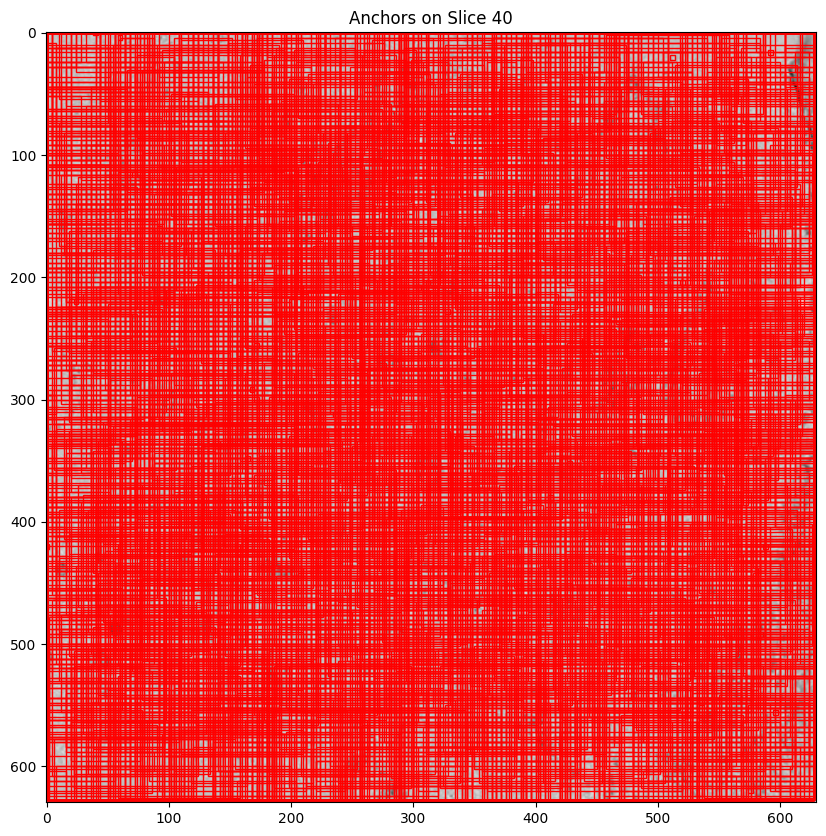

In [208]:
def visualize_anchors(tomogram, anchors, slice_index, max_anchors=100):
    """
    Visualizes a subset of anchor boxes on a specific slice of the tomogram.

    Args:
        tomogram (np.ndarray): 3D tomogram data.
        anchors (np.ndarray): Array of anchor boxes with shape (N, 6).
        slice_index (int): Index of the slice to visualize.
        max_anchors (int): Maximum number of anchors to visualize.
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(tomogram[slice_index], cmap='gray')
    ax = plt.gca()
    count = 0
    
    num_boxes = anchor_boxes.shape[0]
    indices = np.random.choice(num_boxes, size=max_anchors, replace=False)
    random_anchors=anchor_boxes[indices]
    
    for anchor in random_anchors:
        x_min, y_min, z_min, x_max, y_max, z_max = anchor*4
        
        if z_min <= slice_index < z_max:
            rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
    plt.title(f"Anchors on Slice {slice_index}")
    plt.show() 
    
# (Optional) Visualize a subset of anchors on a specific slice
if tomograms_train:
    slice_index = 40  # Adjust as needed
    visualize_anchors(tomograms_train[0]['tomogram'], anchor_boxes, slice_index, max_anchors=10000)
else:
    print("No training tomograms available for visualization.")


In [ ]:
def match_anchors(anchor_boxes, ground_truth_boxes, ground_truth_labels, iou_thresholds=(0.3, 0.7)):
    """
    Matches anchor boxes to ground truth boxes and assigns labels.

    Args:
        anchor_boxes (np.ndarray): Array of anchor boxes with shape (N, 6), 
                                   where each box is (x_min, y_min, z_min, x_max, y_max, z_max).
        ground_truth_boxes (np.ndarray): Array of ground truth boxes with shape (M, 6), 
                                         where each box is (x_min, y_min, z_min, x_max, y_max, z_max).
        ground_truth_labels (np.ndarray): Array of labels for ground truth boxes with shape (M,).
        iou_thresholds (tuple): Tuple of (low_threshold, high_threshold) for negative and positive IoU.

    Returns:
        anchor_labels (np.ndarray): Array of labels for each anchor (-1 for ignored, 0 for background, positive int for classes).
        anchor_deltas (np.ndarray): Array of deltas (dx, dy, dz, dw, dh, dd) for each positive anchor.
        best_gt_idx (np.ndarray): Array of indices of best ground truth box for each anchor.
    """
    low_threshold, high_threshold = iou_thresholds
    num_anchors = anchor_boxes.shape[0]
    num_gt = ground_truth_boxes.shape[0]

    # Initialize labels (-1 means ignored, 0 means background)
    anchor_box_labels = np.full(num_anchors, -1)
    anchor_box_deltas = np.zeros((num_anchors, 6))

    # Compute IoU between each anchor and each ground truth box
    iou_matrix = compute_iou_3d(anchor_boxes, ground_truth_boxes)

    # Find the best matching ground truth box for each anchor
    best_gt_idx = np.argmax(iou_matrix, axis=1)  # Index of best ground truth box for each anchor
    best_iou = np.max(iou_matrix, axis=1)  # Best IoU for each anchor

    # Assign positive labels to anchors with IoU > high_threshold
    positive_indices = np.where(best_iou >= high_threshold)[0]
    anchor_box_labels[positive_indices] = ground_truth_labels[best_gt_idx[positive_indices]]

    # Assign negative labels to anchors with IoU < low_threshold
    negative_indices = np.where(best_iou < low_threshold)[0]
    anchor_box_labels[negative_indices] = 0  # Background label

    # Ignore anchors with low_threshold <= IoU < high_threshold
    ignore_indices = np.where((best_iou >= low_threshold) & (best_iou < high_threshold))[0]
    anchor_box_labels[ignore_indices] = -1

    # Compute deltas for positive anchors
    for idx in positive_indices:
        gt_box = ground_truth_boxes[best_gt_idx[idx]]
        anchor_box = anchor_boxes[idx]
        anchor_box_deltas[idx] = compute_deltas(anchor_box, gt_box)

    return anchor_box_labels, anchor_box_deltas, best_gt_idx



def compute_iou_3d(boxes1, boxes2):
    """
    Computes IoU (Intersection over Union) between two sets of 3D boxes.

    Args:
        boxes1 (np.ndarray): Array of boxes with shape (N, 6), where each box is (x_min, y_min, z_min, x_max, y_max, z_max).
        boxes2 (np.ndarray): Array of boxes with shape (M, 6), where each box is (x_min, y_min, z_min, x_max, y_max, z_max).

    Returns:
        np.ndarray: IoU matrix of shape (N, M), where IoU[i, j] is the IoU between boxes1[i] and boxes2[j].
    """
    N = boxes1.shape[0]
    M = boxes2.shape[0]
    
    # Compute the intersection coordinates
    x_min_inter = np.maximum(boxes1[:, np.newaxis, 0], boxes2[np.newaxis, :, 0])
    y_min_inter = np.maximum(boxes1[:, np.newaxis, 1], boxes2[np.newaxis, :, 1])
    z_min_inter = np.maximum(boxes1[:, np.newaxis, 2], boxes2[np.newaxis, :, 2])
    x_max_inter = np.minimum(boxes1[:, np.newaxis, 3], boxes2[np.newaxis, :, 3])
    y_max_inter = np.minimum(boxes1[:, np.newaxis, 4], boxes2[np.newaxis, :, 4])
    z_max_inter = np.minimum(boxes1[:, np.newaxis, 5], boxes2[np.newaxis, :, 5])

    # Compute the intersection volume
    inter_w = np.maximum(0, x_max_inter - x_min_inter)
    inter_h = np.maximum(0, y_max_inter - y_min_inter)
    inter_d = np.maximum(0, z_max_inter - z_min_inter)
    intersection_volume = inter_w * inter_h * inter_d

    # Compute the volume of each box
    volume1 = (boxes1[:, 3] - boxes1[:, 0]) * (boxes1[:, 4] - boxes1[:, 1]) * (boxes1[:, 5] - boxes1[:, 2])
    volume2 = (boxes2[:, 3] - boxes2[:, 0]) * (boxes2[:, 4] - boxes2[:, 1]) * (boxes2[:, 5] - boxes2[:, 2])

    # Compute the union volume
    union_volume = volume1[:, np.newaxis] + volume2[np.newaxis, :] - intersection_volume

    iou = intersection_volume / union_volume
    return iou

def compute_deltas(anchor_box, gt_box):
    """
    Computes deltas (dx, dy, dz, dw, dh, dd) for transforming an anchor box into a ground truth box.

    Args:
        anchor_box (np.ndarray): Anchor box as (x_min, y_min, z_min, x_max, y_max, z_max).
        gt_box (np.ndarray): Ground truth box as (x_min, y_min, z_min, x_max, y_max, z_max).

    Returns:
        np.ndarray: Deltas (dx, dy, dz, dw, dh, dd).
    """
    # Compute centers and sizes
    x_a = (anchor_box[0] + anchor_box[3]) / 2.0
    y_a = (anchor_box[1] + anchor_box[4]) / 2.0
    z_a = (anchor_box[2] + anchor_box[5]) / 2.0
    w_a = anchor_box[3] - anchor_box[0]
    h_a = anchor_box[4] - anchor_box[1]
    d_a = anchor_box[5] - anchor_box[2]
    
    x_g = (gt_box[0] + gt_box[3]) / 2.0
    y_g = (gt_box[1] + gt_box[4]) / 2.0
    z_g = (gt_box[2] + gt_box[5]) / 2.0
    w_g = gt_box[3] - gt_box[0]
    h_g = gt_box[4] - gt_box[1]
    d_g = gt_box[5] - gt_box[2]
    
    # Compute deltas
    dx = (x_g - x_a) / w_a
    dy = (y_g - y_a) / h_a
    dz = (z_g - z_a) / d_a
    dw = np.log(w_g / w_a)
    dh = np.log(h_g / h_a)
    dd = np.log(d_g / d_a)
    
    return np.array([dx, dy, dz, dw, dh, dd])


anchor_boxes_tomogram_space = anchor_boxes * np.array([stride_x, stride_y, stride_z, stride_x, stride_y, stride_z])


# Randomly sample 10,000 anchors
num_boxes = anchor_boxes_tomogram_space.shape[0]
indices = np.random.choice(num_boxes, size=1000000, replace=False)
random_anchors = anchor_boxes_tomogram_space[indices]

# Match anchors to ground truth boxes using IoU thresholds
anchor_labels, anchor_deltas, best_gt_idx = match_anchors(
    random_anchors,
    ground_truth_boxes,
    ground_truth_labels,
    iou_thresholds=(0.3, 0.7)
)

In [200]:
decoded_labels = [id_to_label[label] for label in anchor_labels if label > 0]
print("Decoded matched labels:", decoded_labels)

Decoded matched labels: ['thyroglobulin', 'virus-like-particle', 'thyroglobulin', 'thyroglobulin']


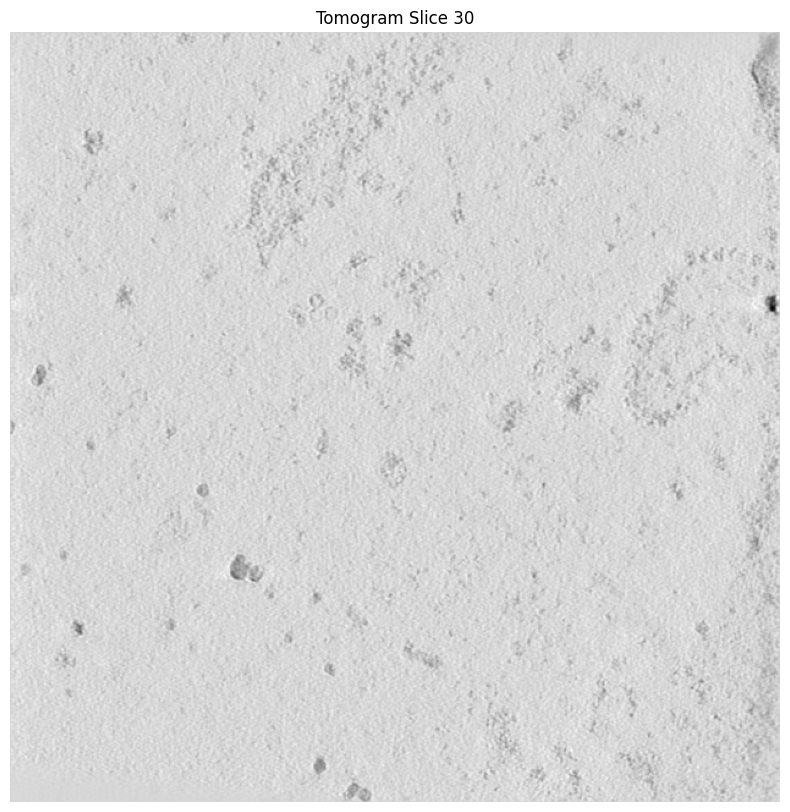

In [207]:
def plot_tomogram_with_matches(tomogram, anchors, anchor_labels, best_gt_idx, ground_truth_boxes, ground_truth_labels, slice_index, id_to_label, max_anchors=100):
    """
    Plots a tomogram slice with matched anchors and their corresponding ground truth boxes overlaid.

    Args:
        tomogram (np.ndarray): 3D tomogram data of shape (D, H, W).
        anchors (np.ndarray): Array of anchor boxes with shape (N, 6).
        anchor_labels (np.ndarray): Array of labels for each anchor (-1, 0, positive int).
        best_gt_idx (np.ndarray): Array of indices of best ground truth box for each anchor.
        ground_truth_boxes (np.ndarray): Array of ground truth boxes with shape (M, 6).
        ground_truth_labels (np.ndarray): Array of ground truth labels with shape (M,).
        slice_index (int): Index of the slice to visualize along the z-axis.
        id_to_label (dict): Mapping of integer IDs to particle labels.
        max_anchors (int): Maximum number of anchors to plot to avoid clutter.
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot the tomogram slice
    ax.imshow(tomogram[slice_index], cmap='gray')
    ax.set_title(f"Tomogram Slice {slice_index}")
    
    # To avoid duplicate labels in legend
    plotted_labels = set()
    
    # Filter positive anchors that overlap the slice
    pos_indices = np.where((anchor_labels > 0) & 
                           (anchors[:, 2] <= slice_index) & 
                           (anchors[:, 5] > slice_index))[0]
    
    # Randomly select a subset of positive anchors
    if len(pos_indices) > max_anchors:
        selected_indices = np.random.choice(pos_indices, size=max_anchors, replace=False)
    else:
        selected_indices = pos_indices
    
    for i in selected_indices:
        anchor = anchors[i]
        label = anchor_labels[i]
        gt_idx = best_gt_idx[i]
        
        # Decode label to its original particle type
        particle_type = id_to_label[label]
        
        # Draw anchor box
        x_min, y_min, z_min, x_max, y_max, z_max = anchor
        if 'Matched Anchor' not in plotted_labels:
            rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                     linewidth=1.5, edgecolor='red', facecolor='none', label='Matched Anchor')
            ax.add_patch(rect)
            plotted_labels.add('Matched Anchor')
        else:
            rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                     linewidth=1.5, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
        
        # Draw the corresponding ground truth box if it overlaps the slice
        gt_box = ground_truth_boxes[gt_idx]
        gt_x_min, gt_y_min, gt_z_min, gt_x_max, gt_y_max, gt_z_max = gt_box
        if gt_z_min <= slice_index <= gt_z_max:
            if 'Ground Truth' not in plotted_labels:
                rect = patches.Rectangle((gt_x_min, gt_y_min), gt_x_max - gt_x_min, gt_y_max - gt_y_min, 
                                         linewidth=1.5, edgecolor='blue', facecolor='none', linestyle='--', label='Ground Truth')
                ax.add_patch(rect)
                plotted_labels.add('Ground Truth')
            else:
                rect = patches.Rectangle((gt_x_min, gt_y_min), gt_x_max - gt_x_min, gt_y_max - gt_y_min, 
                                         linewidth=1.5, edgecolor='blue', facecolor='none', linestyle='--')
                ax.add_patch(rect)
            
            # Annotate the particle type
            ax.text(gt_x_min, gt_y_min - 5, particle_type, color='white', fontsize=8, backgroundcolor='black')
    
    # Add legend without duplicates
    if plotted_labels:
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys())
    
    ax.axis('off')
    plt.show()


# Generate reverse mapping for decoding labels
id_to_label = {idx: label for label, idx in label_to_id.items()}

# Choose a slice to visualize
slice_index = 30  # Adjust based on your tomogram's depth

# Call the visualization function
plot_tomogram_with_matches(
    tomogram=tomograms_train[0]['tomogram'],
    anchors=random_anchors,
    anchor_labels=anchor_labels,
    best_gt_idx=best_gt_idx,
    ground_truth_boxes=ground_truth_boxes,
    ground_truth_labels=ground_truth_labels,
    slice_index=slice_index,
    id_to_label=id_to_label,
    max_anchors=100  # Adjust to limit the number of anchors plotted
)


In [202]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def extract_box_dimensions(ground_truth_boxes):
    """
    Extracts the width, height, and depth from ground truth boxes.

    Args:
        ground_truth_boxes (np.ndarray): Array of ground truth boxes with shape (N, 6).

    Returns:
        np.ndarray: Array of widths.
        np.ndarray: Array of heights.
        np.ndarray: Array of depths.
    """
    widths = ground_truth_boxes[:, 3] - ground_truth_boxes[:, 0]
    heights = ground_truth_boxes[:, 4] - ground_truth_boxes[:, 1]
    depths = ground_truth_boxes[:, 5] - ground_truth_boxes[:, 2]
    return widths, heights, depths

# Extract dimensions
widths, heights, depths = extract_box_dimensions(ground_truth_boxes)

# Create a DataFrame for easier handling
dimensions_df = pd.DataFrame({
    'width': widths,
    'height': heights,
    'depth': depths
})

print(dimensions_df.describe())
dimensions_df


             width       height        depth
count  1269.000000  1269.000000  1269.000000
mean     21.397951    21.397951    21.397951
std       7.634392     7.634392     7.634392
min      12.000000    12.000000    12.000000
25%      12.000000    12.000000    12.000000
50%      26.000000    26.000000    26.000000
75%      30.000000    30.000000    30.000000
max      30.000000    30.000000    30.000000


,width,height,depth
0,30.0,30.0,30.0
1,30.0,30.0,30.0
2,30.0,30.0,30.0
3,30.0,30.0,30.0
4,30.0,30.0,30.0
...,...,...,...
1264,26.0,26.0,26.0
1265,26.0,26.0,26.0
1266,26.0,26.0,26.0
1267,26.0,26.0,26.0


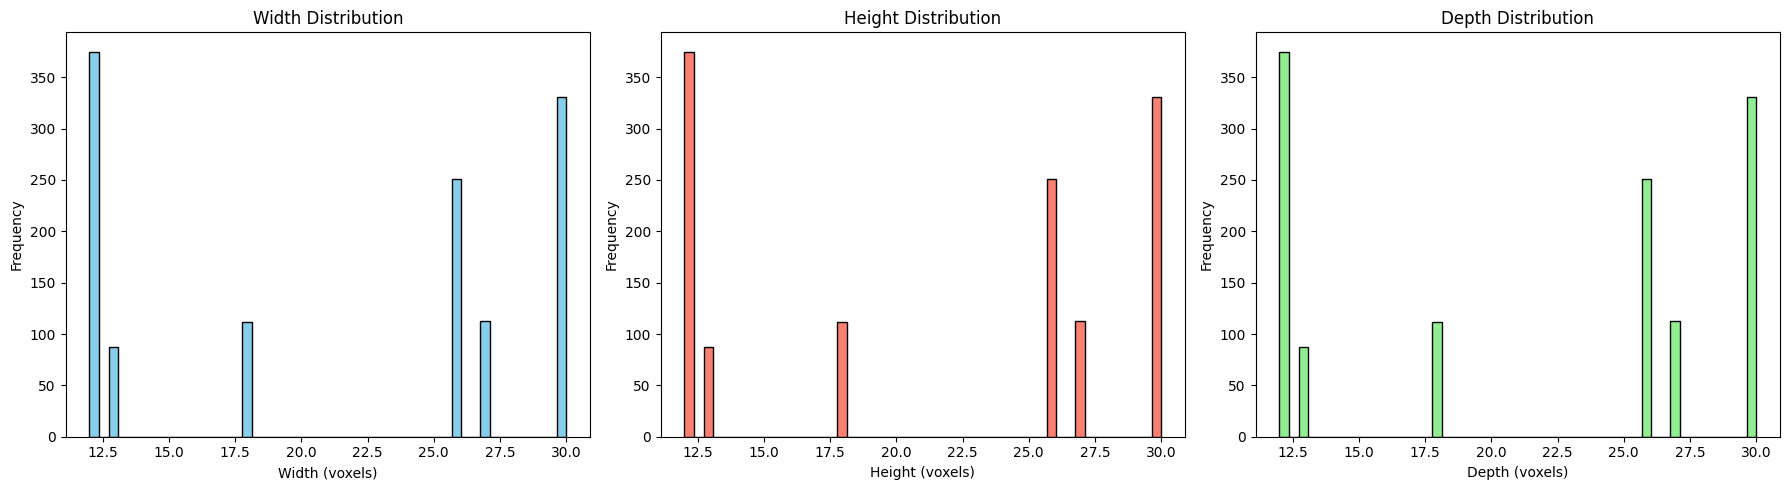

In [203]:
def plot_dimension_histograms(dimensions_df):
    """
    Plots histograms for width, height, and depth of ground truth boxes.

    Args:
        dimensions_df (pd.DataFrame): DataFrame containing 'width', 'height', 'depth'.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    axes[0].hist(dimensions_df['width'], bins=50, color='skyblue', edgecolor='black')
    axes[0].set_title('Width Distribution')
    axes[0].set_xlabel('Width (voxels)')
    axes[0].set_ylabel('Frequency')
    
    axes[1].hist(dimensions_df['height'], bins=50, color='salmon', edgecolor='black')
    axes[1].set_title('Height Distribution')
    axes[1].set_xlabel('Height (voxels)')
    axes[1].set_ylabel('Frequency')
    
    axes[2].hist(dimensions_df['depth'], bins=50, color='lightgreen', edgecolor='black')
    axes[2].set_title('Depth Distribution')
    axes[2].set_xlabel('Depth (voxels)')
    axes[2].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# Plot histograms
plot_dimension_histograms(dimensions_df)


In [204]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def prepare_clustering_data(dimensions_df, num_clusters=5):
    """
    Prepares data for k-means clustering.

    Args:
        dimensions_df (pd.DataFrame): DataFrame containing 'width', 'height', 'depth'.
        num_clusters (int): Number of clusters for k-means.

    Returns:
        np.ndarray: Cluster centers.
        KMeans: Fitted k-means model.
    """
    # Feature matrix
    X = dimensions_df[['width', 'height', 'depth']].values
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Perform k-means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(X_scaled)
    
    # Get cluster centers in original scale
    cluster_centers_scaled = kmeans.cluster_centers_
    cluster_centers = scaler.inverse_transform(cluster_centers_scaled)
    
    return cluster_centers, kmeans

# Determine number of clusters (you can adjust this)
num_clusters = 5
cluster_centers, kmeans_model = prepare_clustering_data(dimensions_df, num_clusters=num_clusters)

print("Cluster Centers (width, height, depth):")
print(cluster_centers)


Cluster Centers (width, height, depth):
[[26.31043956 26.31043956 26.31043956]
 [13.         13.         13.        ]
 [30.         30.         30.        ]
 [18.         18.         18.        ]
 [12.         12.         12.        ]]


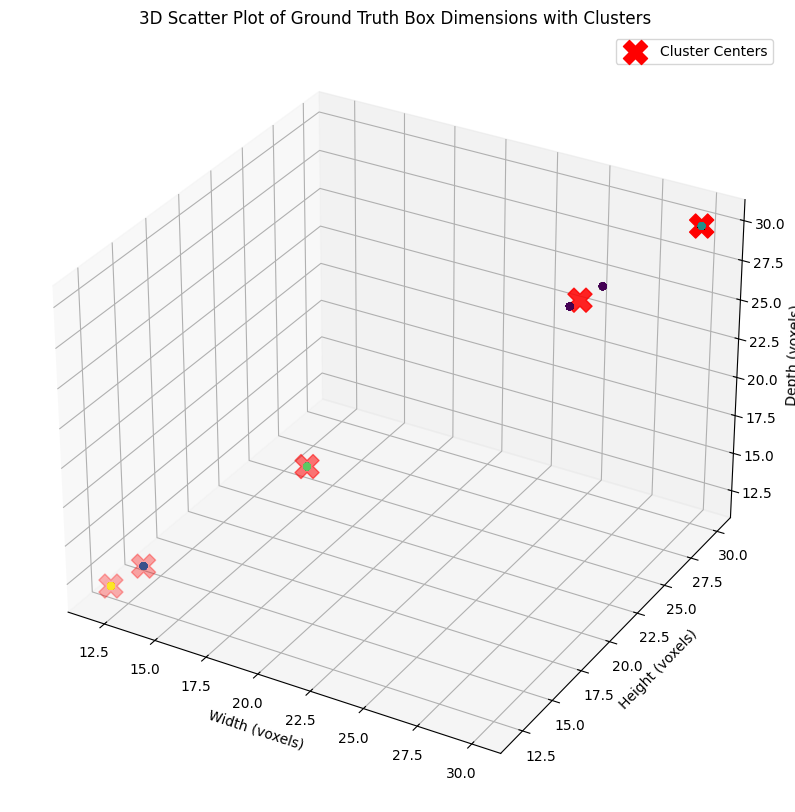

In [205]:
def plot_clusters(dimensions_df, cluster_centers, kmeans_model):
    """
    Plots the clusters of ground truth box dimensions.

    Args:
        dimensions_df (pd.DataFrame): DataFrame containing 'width', 'height', 'depth'.
        cluster_centers (np.ndarray): Array of cluster centers.
        kmeans_model (KMeans): Fitted k-means model.
    """
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Scatter plot of the dimensions colored by cluster
    scatter = ax.scatter(dimensions_df['width'], dimensions_df['height'], dimensions_df['depth'],
                         c=kmeans_model.labels_, cmap='viridis', alpha=0.5)
    
    # Plot cluster centers
    ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], cluster_centers[:, 2],
               c='red', s=300, marker='X', label='Cluster Centers')
    
    ax.set_title('3D Scatter Plot of Ground Truth Box Dimensions with Clusters')
    ax.set_xlabel('Width (voxels)')
    ax.set_ylabel('Height (voxels)')
    ax.set_zlabel('Depth (voxels)')
    ax.legend()
    plt.show()

# Plot the clusters
plot_clusters(dimensions_df, cluster_centers, kmeans_model)


In [206]:
particle_locations_df.lis

AttributeError: 'DataFrame' object has no attribute 'lis'